## Finetuning Hugging Face models to Financial Phrase Bank Dataset

## Exploring Data

In [ ]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install torch
# !pip install torchvision
# !pip install torchaudio
# !pip install transformers
# !pip install scikit-learn
# !pip install tqdm

In [44]:
#>=50% of annotators agreed on the financial sentiment 
from pathlib import Path
import pandas as pd

# Load the CSV file with the specified encoding and column names
df = pd.read_csv('all-data.csv',encoding='windows-1252', header=None, names=['label', 'headline'])

# Check the first few rows of the data
df.head()

,label,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [45]:
import re
# Cleaning function
def clean_text(text):
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation and special characters (except spaces)
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [46]:
#clean headlines
df['headline'] = df['headline'].apply(clean_text)

## Fine-tuning Deberta

In [47]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the pre-trained tokenizer and model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

c:\Users\Tammy\anaconda3\Lib\site-packages\transformers\convert_slow_tokenizer.py:558: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


## Tackling data imbalance using undersampling

In [48]:
category_counts = df['label'].value_counts()

print(category_counts)

label
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64


In [49]:
import numpy as np

def undersample_labels(df):
    """
    Undersamples the DataFrame so that each class in the 'label' column 
    has the same number of samples as the least frequent class.

    Parameters:
    df (pd.DataFrame): The input DataFrame with a 'label' column.

    Returns:
    pd.DataFrame: The undersampled DataFrame.
    """

    # Find the least frequent class count
    min_class_size = df['label'].value_counts().min()

    # Initialize an empty list to store undersampled data
    undersampled_data = []

    # Iterate through each unique class in 'label' and sample data
    for label in df['label'].unique():
        sampled_df = df[df['label'] == label].sample(n=min_class_size, random_state=42, replace=False)
        undersampled_data.append(sampled_df)

    # Combine sampled data, shuffle, and reset index
    undersampled_df = pd.concat(undersampled_data).sample(frac=1, random_state=42).reset_index(drop=True)

    return undersampled_df

In [50]:
undersampled_df = undersample_labels(df)
undersampled_df['label'].value_counts()

label
positive    604
negative    604
neutral     604
Name: count, dtype: int64

## Train Test Split

In [51]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=100):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
      text = str(self.texts[idx])
      label = torch.tensor(self.labels[idx])

      encoding = self.tokenizer(text, truncation=True, padding="max_length",
                                max_length=self.max_len)

      return {
          'input_ids': torch.tensor(encoding['input_ids']),
          'attention_mask': torch.tensor(encoding['attention_mask']),
          'labels': label
      }

In [52]:
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {"negative": 0, "neutral": 1, "positive": 2}

X = undersampled_df['headline'].tolist()
y = undersampled_df['label'].map(label2id).tolist()

# dataset = CustomDataset(X, y, tokenizer)

In [53]:
from sklearn.model_selection import train_test_split

# Split the texts and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the datasets
train_dataset = CustomDataset(X_train, y_train, tokenizer)
test_dataset = CustomDataset(X_test, y_test, tokenizer)

## Training

In [54]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(example):
  labels = example.label_ids
  preds = example.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average="macro")
  acc = accuracy_score(labels, preds)

  return {'accuracy': acc, "f1": f1}

In [55]:
from transformers import Trainer, TrainingArguments

batch_size = 16
model_name = "Fin_DeBerta"

args = TrainingArguments(
    output_dir="output",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=3,
    evaluation_strategy='epoch',
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,
    gradient_accumulation_steps=2,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    logging_steps=50,
    report_to="none"
)

c:\Users\Tammy\anaconda3\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [56]:
trainer = Trainer(model=model,
                  args=args,
                  train_dataset = train_dataset,
                  eval_dataset = test_dataset,
                  compute_metrics=compute_metrics,
                  tokenizer = tokenizer)

In [57]:
trainer.train()

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.3843551576137543, 'eval_accuracy': 0.8457300275482094, 'eval_f1': 0.8478258099861127, 'eval_runtime': 31.0643, 'eval_samples_per_second': 11.685, 'eval_steps_per_second': 0.74, 'epoch': 0.99}
{'loss': 0.5696, 'grad_norm': 5.55584716796875, 'learning_rate': 1.5940688504813664e-05, 'epoch': 1.1}


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.3231792747974396, 'eval_accuracy': 0.8760330578512396, 'eval_f1': 0.8777945690986569, 'eval_runtime': 39.5678, 'eval_samples_per_second': 9.174, 'eval_steps_per_second': 0.581, 'epoch': 2.0}
{'loss': 0.23, 'grad_norm': 2.977994203567505, 'learning_rate': 4.059311495186338e-06, 'epoch': 2.2}


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.316120445728302, 'eval_accuracy': 0.8732782369146006, 'eval_f1': 0.8761255848068817, 'eval_runtime': 37.663, 'eval_samples_per_second': 9.638, 'eval_steps_per_second': 0.611, 'epoch': 2.97}
{'train_runtime': 2828.5165, 'train_samples_per_second': 1.537, 'train_steps_per_second': 0.048, 'train_loss': 0.3385294031213831, 'epoch': 2.97}


TrainOutput(global_step=135, training_loss=0.3385294031213831, metrics={'train_runtime': 2828.5165, 'train_samples_per_second': 1.537, 'train_steps_per_second': 0.048, 'total_flos': 221286463866000.0, 'train_loss': 0.3385294031213831, 'epoch': 2.967032967032967})

In [58]:
# Update compute_metrics with the macro F1 score
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(example):
    labels = example.label_ids
    preds = example.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="macro")  # Using macro now
    acc = accuracy_score(labels, preds)

    return {'accuracy': acc, 'f1': f1}

# Re-evaluate the model
results = trainer.evaluate(eval_dataset=test_dataset)
print(results)


  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.316120445728302, 'eval_accuracy': 0.8732782369146006, 'eval_f1': 0.8761255848068817, 'eval_runtime': 37.4288, 'eval_samples_per_second': 9.698, 'eval_steps_per_second': 0.614, 'epoch': 2.967032967032967}


In [59]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
predictions_output = trainer.predict(test_dataset)
preds = np.argmax(predictions_output.predictions, axis=-1)
labels = predictions_output.label_ids


  0%|          | 0/23 [00:00<?, ?it/s]

In [60]:
cm = confusion_matrix(labels, preds)


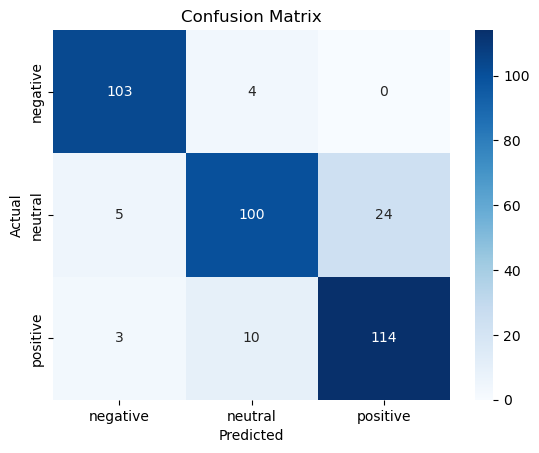

In [61]:
# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [69]:
#saving the model locally
model.save_pretrained("./Fin_DeBerta")
tokenizer.save_pretrained("./Fin_DeBerta")


('./Fin_DeBerta\\tokenizer_config.json',
 './Fin_DeBerta\\special_tokens_map.json',
 './Fin_DeBerta\\spm.model',
 './Fin_DeBerta\\added_tokens.json',
 './Fin_DeBerta\\tokenizer.json')

### Conclusion: For the finetuned deberta model, the accuracy is 87.3% anf f1 score is also around 87.6%

## Repeat on non fine-tuned model

In [62]:
#Load in pre-trained deberta model from Huggingface
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the pre-trained tokenizer and model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

c:\Users\Tammy\anaconda3\Lib\site-packages\transformers\convert_slow_tokenizer.py:558: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [63]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Reuse your compute_metrics function
)


In [64]:
results_pretrained = trainer.evaluate(eval_dataset=test_dataset)
print("Pre-trained Model Performance:", results_pretrained)

  0%|          | 0/46 [00:00<?, ?it/s]

Pre-trained Model Performance: {'eval_loss': 1.0314403772354126, 'eval_model_preparation_time': 0.0059, 'eval_accuracy': 0.5702479338842975, 'eval_f1': 0.5822471117144926, 'eval_runtime': 29.0951, 'eval_samples_per_second': 12.476, 'eval_steps_per_second': 1.581}


In [65]:
predictions_output = trainer.predict(test_dataset)

preds = np.argmax(predictions_output.predictions, axis=-1)
labels = predictions_output.label_ids

accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='macro')

print(f"Pre-trained Accuracy: {accuracy:.4f}")
print(f"Pre-trained F1 Score (Macro): {f1:.4f}")


  0%|          | 0/46 [00:00<?, ?it/s]

Pre-trained Accuracy: 0.5702
Pre-trained F1 Score (Macro): 0.5822


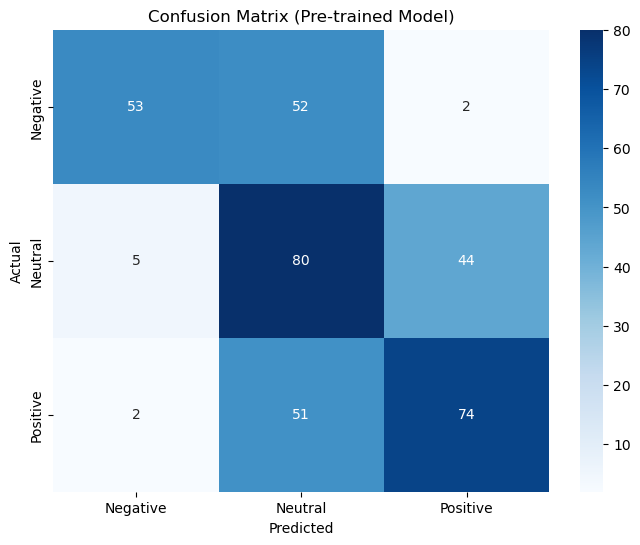

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Pre-trained Model)")
plt.show()


## Visualizing results of pre-trained vs finetuned model

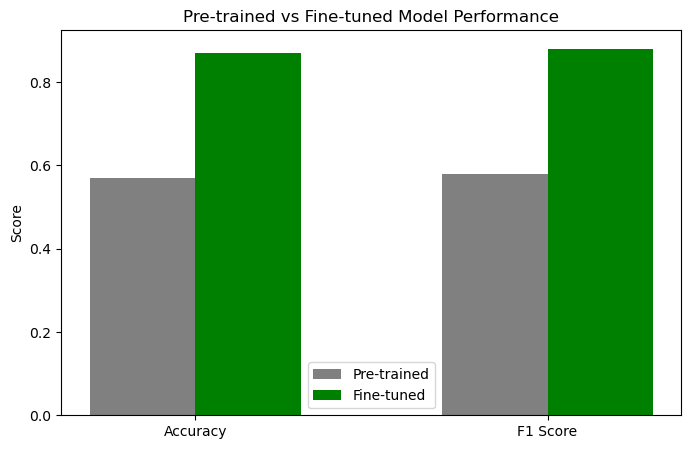

In [68]:
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'F1 Score']
pretrained_scores = [0.57, 0.58]  # Replace with actual results
finetuned_scores = [0.87, 0.88]   # Replace with actual results

x = range(len(metrics))

plt.figure(figsize=(8, 5))
plt.bar(x, pretrained_scores, width=0.3, label='Pre-trained', color='gray')
plt.bar([p + 0.3 for p in x], finetuned_scores, width=0.3, label='Fine-tuned', color='green')
plt.xticks([p + 0.15 for p in x], metrics)
plt.ylabel("Score")
plt.title("Pre-trained vs Fine-tuned Model Performance")
plt.legend()
plt.show()
